#Testing and Training NLP for Fake News Detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History 

from wordcloud import WordCloud, STOPWORDS

In [4]:
real = pd.read_csv('Fake-News\True.csv')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake = pd.read_csv('Fake-News\Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
real['Category'] = 1
fake['Category'] = 0

In [7]:
print(real.shape)
real.head()

(21417, 5)


,title,text,subject,date,Category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
print(fake.shape)
fake.head()

(23481, 5)


,title,text,subject,date,Category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
dataset = pd.concat([real, fake]).reset_index(drop=True)

In [10]:
print(dataset.shape)
dataset.head()

(44898, 5)


,title,text,subject,date,Category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
import gc
del [[real,fake]]
gc.collect()

80

In [12]:
dataset.isnull().sum()

title       0
text        0
subject     0
date        0
Category    0
dtype: int64

In [13]:
dataset['final_text'] = dataset['title'] + dataset['text']
dataset['final_text'].head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: final_text, dtype: object

In [14]:
dataset['Category'].value_counts()

0    23481
1    21417
Name: Category, dtype: int64

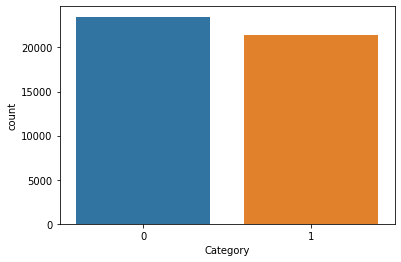

In [15]:
sns.countplot(dataset["Category"])

In [16]:
dataset[['Category','subject','final_text']].groupby(['Category','subject']).count()

final_text
Category subject                    
0        Government News        1570
         Middle-east             778
         News                   9050
         US_News                 783
         left-news              4459
         politics               6841
1        politicsNews          11272
         worldnews             10145

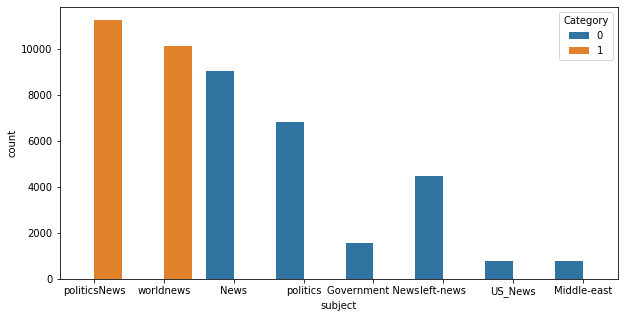

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x= "subject", hue = "Category", data=dataset)

In [18]:
final_text_result = []
for text in dataset['final_text']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    result = result.lower()
    result = result.split()
    result = [r for r in result if r not in set(stopwords.words('english'))]
    final_text_result.append(" ".join(result))

In [19]:
print(len(final_text_result))

44898


In [20]:
X_final = np.array(final_text_result)
y_final = dataset['Category']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [22]:
from tensorflow.keras.preprocessing import text
max_words = 10000
tokenizer = text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [23]:
# Generate sequence of Tokens
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

In [24]:
# Pad the sequences
sent_length = 400
X_train_pad = sequence.pad_sequences(X_train_sequence, maxlen=sent_length)
X_test_pad = sequence.pad_sequences(X_test_sequence, maxlen=sent_length)

In [25]:
word_index = tokenizer.word_index

In [26]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [27]:
dataset = reduce_mem_usage(dataset)
del final_text_result
del X_final
del y_final
del X_train
del X_test
del X_train_sequence
del X_test_sequence
gc.collect()

Memory usage after optimization is: 1.76 MB
Decreased by 14.6%


20

In [28]:
GLOVE_EMBEDDINGS_FILE = 'C:\\Users\\Gandalf\Fake-News\glove.twitter.27B.100d.txt'

In [29]:
%%time
embedding_vectors = {}
with open(GLOVE_EMBEDDINGS_FILE,'r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print("Size of vocabulary in GloVe: ", len(embedding_vectors))  

Size of vocabulary in GloVe:  1193514
Wall time: 40.3 s


In [30]:
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

In [32]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
# lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,117,377
Trainable params: 117,377
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [33]:
%%time
seq_model1 = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

Epoch 1/20
123/123 [==============================] - 179s 1s/step - loss: 0.2128 - accuracy: 0.9186 - val_loss: 0.1146 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 2/20
123/123 [==============================] - 181s 1s/step - loss: 0.1384 - accuracy: 0.9492 - val_loss: 0.5353 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 3/20
123/123 [==============================] - 181s 1s/step - loss: 0.3619 - accuracy: 0.8549 - val_loss: 0.2697 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 4/20
123/123 [==============================] - 180s 1s/step - loss: 0.2422 - accuracy: 0.9014 - val_loss: 0.2198 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 5/20
123/123 [==============================] - 178s 1s/step - loss: 0.1918 - accuracy: 0.9253 - val_loss: 0.1664 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 6/20
123/123 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9492
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
123/123 [==============================] - 

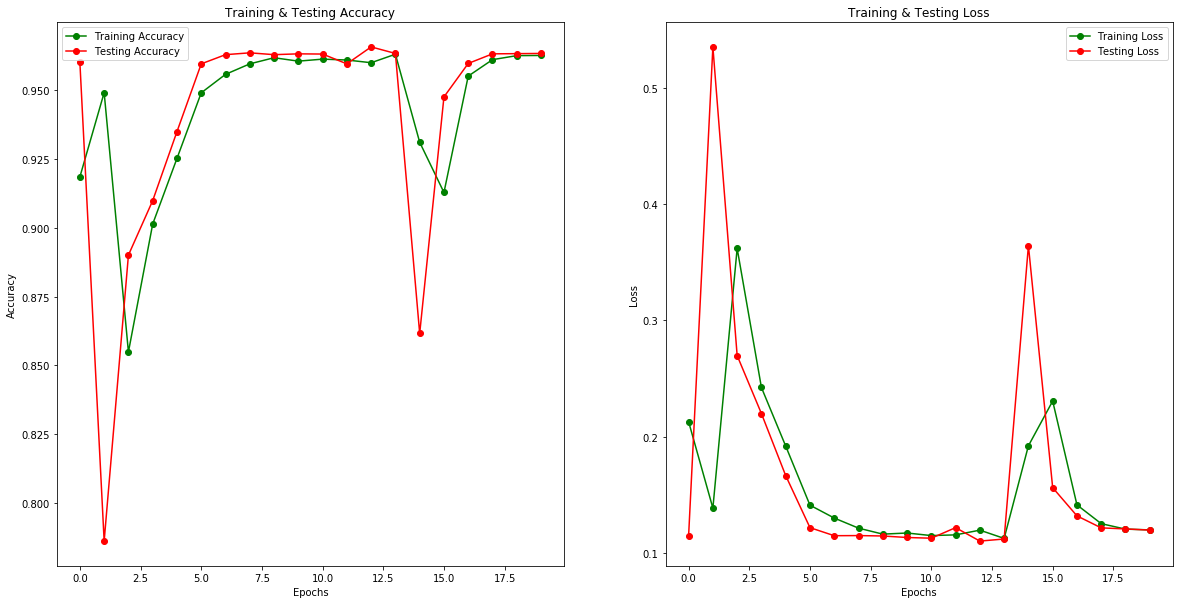

In [34]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = seq_model1.history['accuracy']
train_loss = seq_model1.history['loss']
val_acc = seq_model1.history['val_accuracy']
val_loss = seq_model1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [35]:
train_lstm_results = lstm_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=256)
print("Train accuracy: {}".format(train_lstm_results[1]*100))
print("Test accuracy: {}".format(test_lstm_results[1]*100))

Train accuracy: 96.32174968719482
Test accuracy: 96.34743928909302


In [36]:
y_pred = lstm_model.predict_classes(X_test_pad)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuarcy: 96.35


In [37]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[6742  327]
 [ 165 6236]]


In [38]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      7069
           1       0.95      0.97      0.96      6401

    accuracy                           0.96     13470
   macro avg       0.96      0.96      0.96     13470
weighted avg       0.96      0.96      0.96     13470



In [39]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,088,449
Trainable params: 88,449
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [40]:
%%time
seq_model2 = gru_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

Epoch 1/20
123/123 [==============================] - 161s 1s/step - loss: 0.2316 - accuracy: 0.9057 - val_loss: 0.1308 - val_accuracy: 0.9549 - lr: 0.0010
Epoch 2/20
123/123 [==============================] - 159s 1s/step - loss: 0.1227 - accuracy: 0.9584 - val_loss: 0.0927 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 3/20
123/123 [==============================] - 161s 1s/step - loss: 0.0534 - accuracy: 0.9847 - val_loss: 0.0336 - val_accuracy: 0.9904 - lr: 0.0010
Epoch 4/20
123/123 [==============================] - 161s 1s/step - loss: 0.0328 - accuracy: 0.9916 - val_loss: 0.0146 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 5/20
123/123 [==============================] - 160s 1s/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0117 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 6/20
123/123 [==============================] - 159s 1s/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0091 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 7/20
123/123 [==============================] - 159s 1s/st

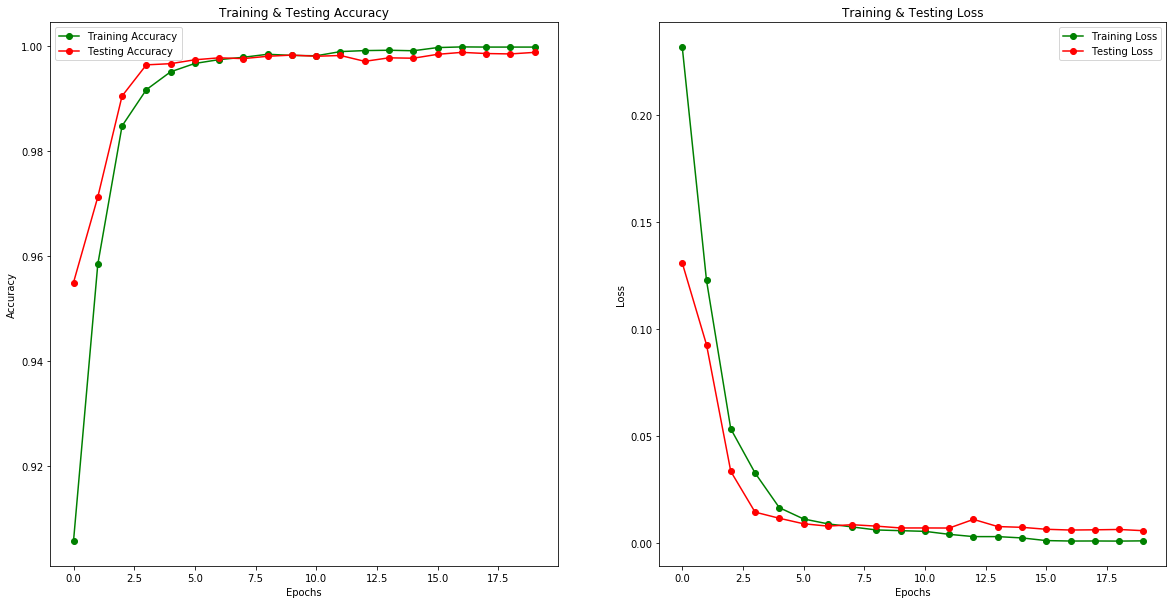

In [41]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = seq_model2.history['accuracy']
train_loss = seq_model2.history['loss']
val_acc = seq_model2.history['val_accuracy']
val_loss = seq_model2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [42]:
train_gru_results = gru_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=256)
print("Train accuracy: {}".format(train_gru_results[1]*100))
print("Test accuracy: {}".format(test_gru_results[1]*100))

Train accuracy: 99.98409152030945
Test accuracy: 99.87379312515259


In [43]:
y_pred = gru_model.predict_classes(X_test_pad)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuarcy: 99.87


In [44]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[7062    7]
 [  10 6391]]


In [45]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

